In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

In [2]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.callbacks import WeightCallback
from neurodiffeq.callbacks import WeightCallback1
from neurodiffeq.callbacks import PeriodLocal

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Pre-Training

NeuralDiffEqs present a unique and powerful way to compute the solution of differential equations. However, it is often the case that these models take thousands of epochs to train. As such, we might want to establish whether a pre-trained model on an equation 'similar' to the test equation can help speed up training. 

we begin our analysis with the harmonic oscillator and initial conditions that sine curve

### Train on the HO with initial conditions that result in sin(t)

<IPython.core.display.Javascript object>


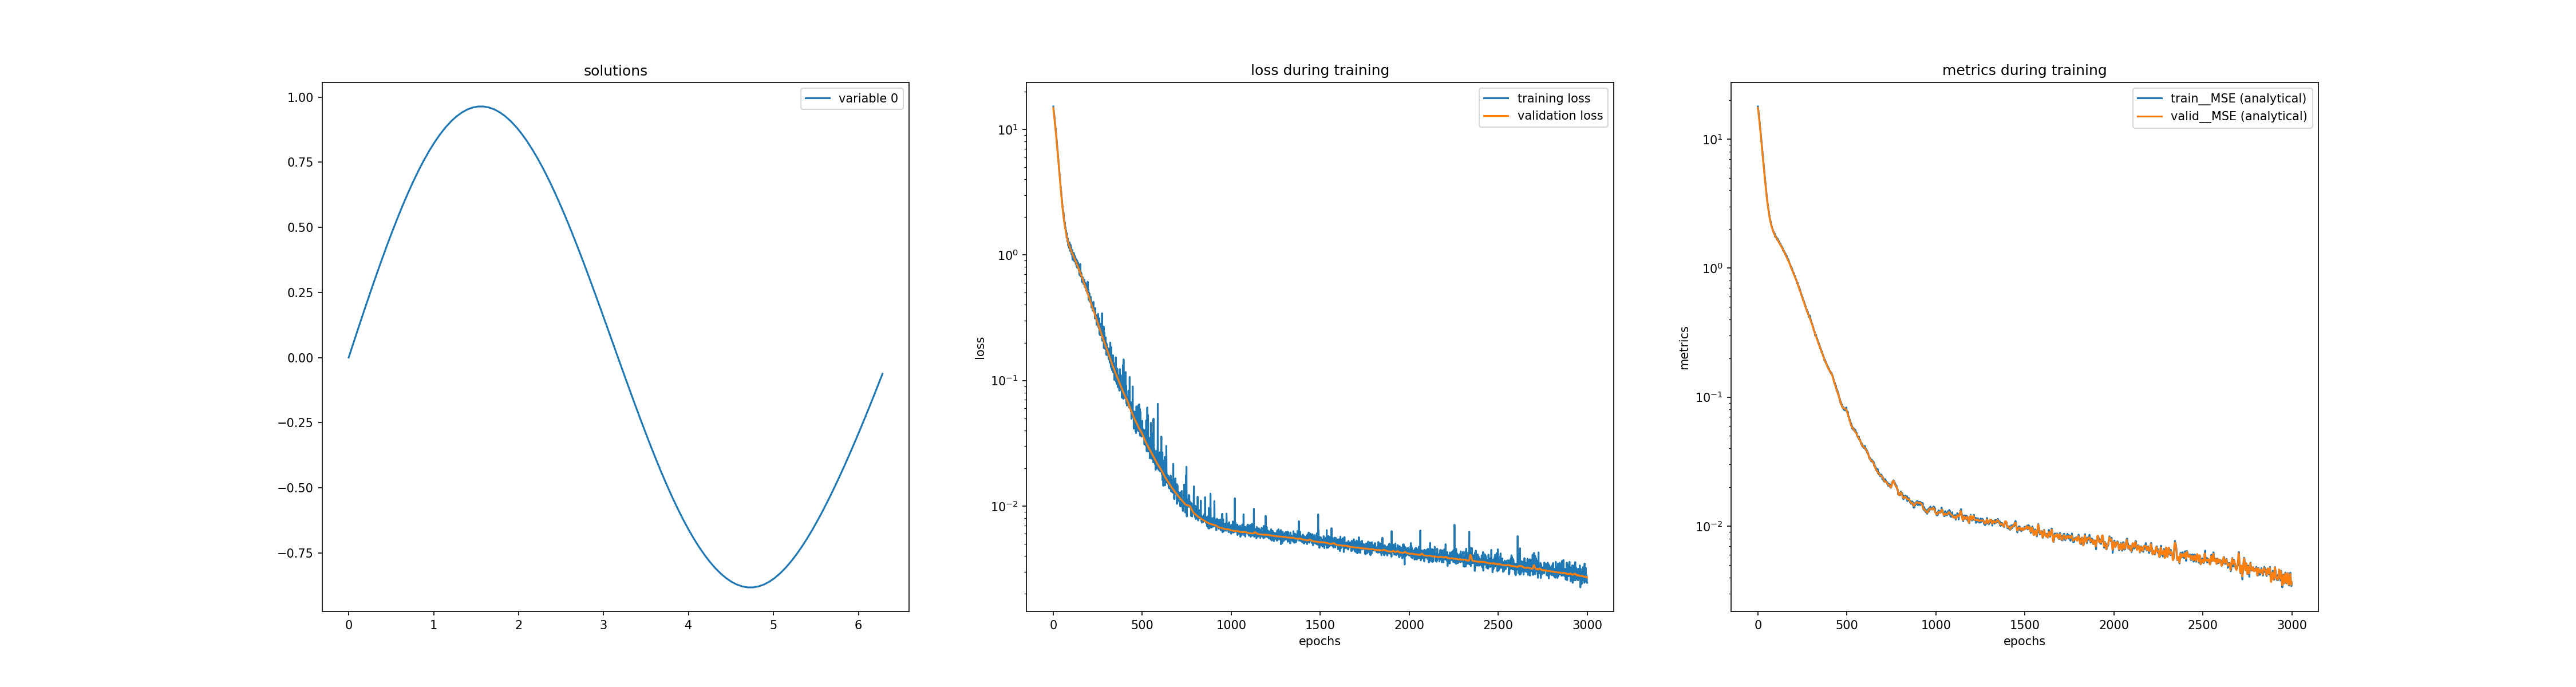

In [3]:
%matplotlib notebook

def mse(u, t):
    true_u = torch.sin(t)
    return torch.mean( (u - true_u)**2 )

harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
init_vals_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

monitor = Monitor1D(t_min=0.0, t_max=2*np.pi)
# monitor_callback = MonitorCallback(monitor)

monitor_callback = PeriodLocal(period=100).set_action_callback(monitor.to_callback())

# Instantiate a solver instance
solver_ho = Solver1D(
    ode_system=harmonic_oscillator,
    conditions=init_vals_ho,
    t_min=0.,
    t_max=2*np.pi, 
    metrics={'MSE (analytical)':mse}
    
)

# Fit the solver (i.e., train the neural networks)
solver_ho.fit(max_epochs=3000, callbacks=[monitor_callback])

# # Get the solution


so we have a trained NN that can produce the sine curve given the HO diffeq with IVP params as specified above. Next, we want to test whether using this as a pre-trained model is beneficial to learning a similar equation but with the frequency of the harmonic oscillator set to sqrt(3). 

This is equivalent to:

$$ m u_{tt} = - ku$$

$$\omega = \sqrt{k/m}$$

with k set to 3 and m to 1. Note: in previous equation we had k as 1 and m as 1.

We first train the network from scratch to serve as a baseline against the pre-trained model.

#### Train the network from scratch with HO but with a freq = sqrt(3)

<IPython.core.display.Javascript object>


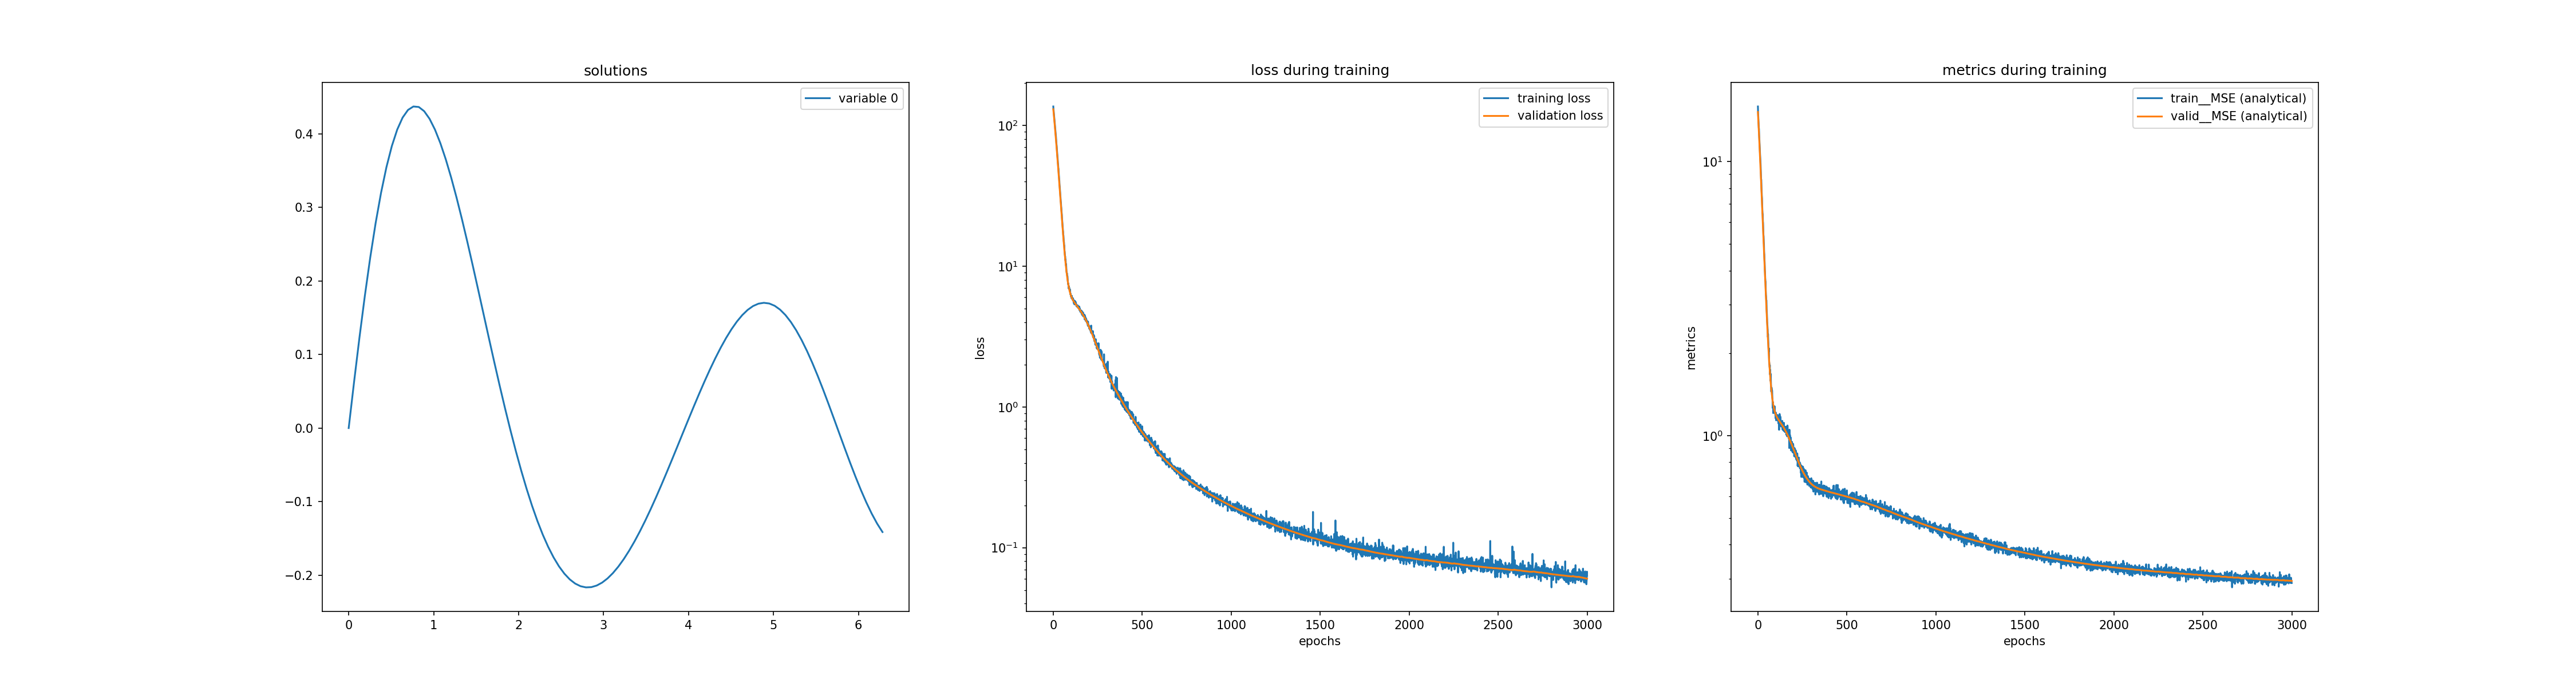

In [4]:
# %matplotlib notebook

def mse(u, t):
    true_u = torch.sin(np.sqrt(3)*t)
    return torch.mean( (u - true_u)**2 )

harmonic_oscillator_cos = lambda u, t: [ diff(u, t, order=2) + 3*u ]
init_vals_ho_cos = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

monitor1 = Monitor1D(t_min=0.0, t_max=2*np.pi)
monitor_callback1 = PeriodLocal(period=100).set_action_callback(monitor1.to_callback())


# Instantiate a solver instance
solver_ho_cos = Solver1D(
    ode_system=harmonic_oscillator_cos,
    conditions=init_vals_ho_cos,
    t_min=0.,
    t_max=2*np.pi,
    metrics = {'MSE (analytical)':mse}
)

# Fit the solver (i.e., train the neural networks)
solver_ho_cos.fit(max_epochs=3000,callbacks=[monitor_callback1])


#### Use the pretrained model of sin(t) to optimize for sin(sqrt(3)t)

<IPython.core.display.Javascript object>


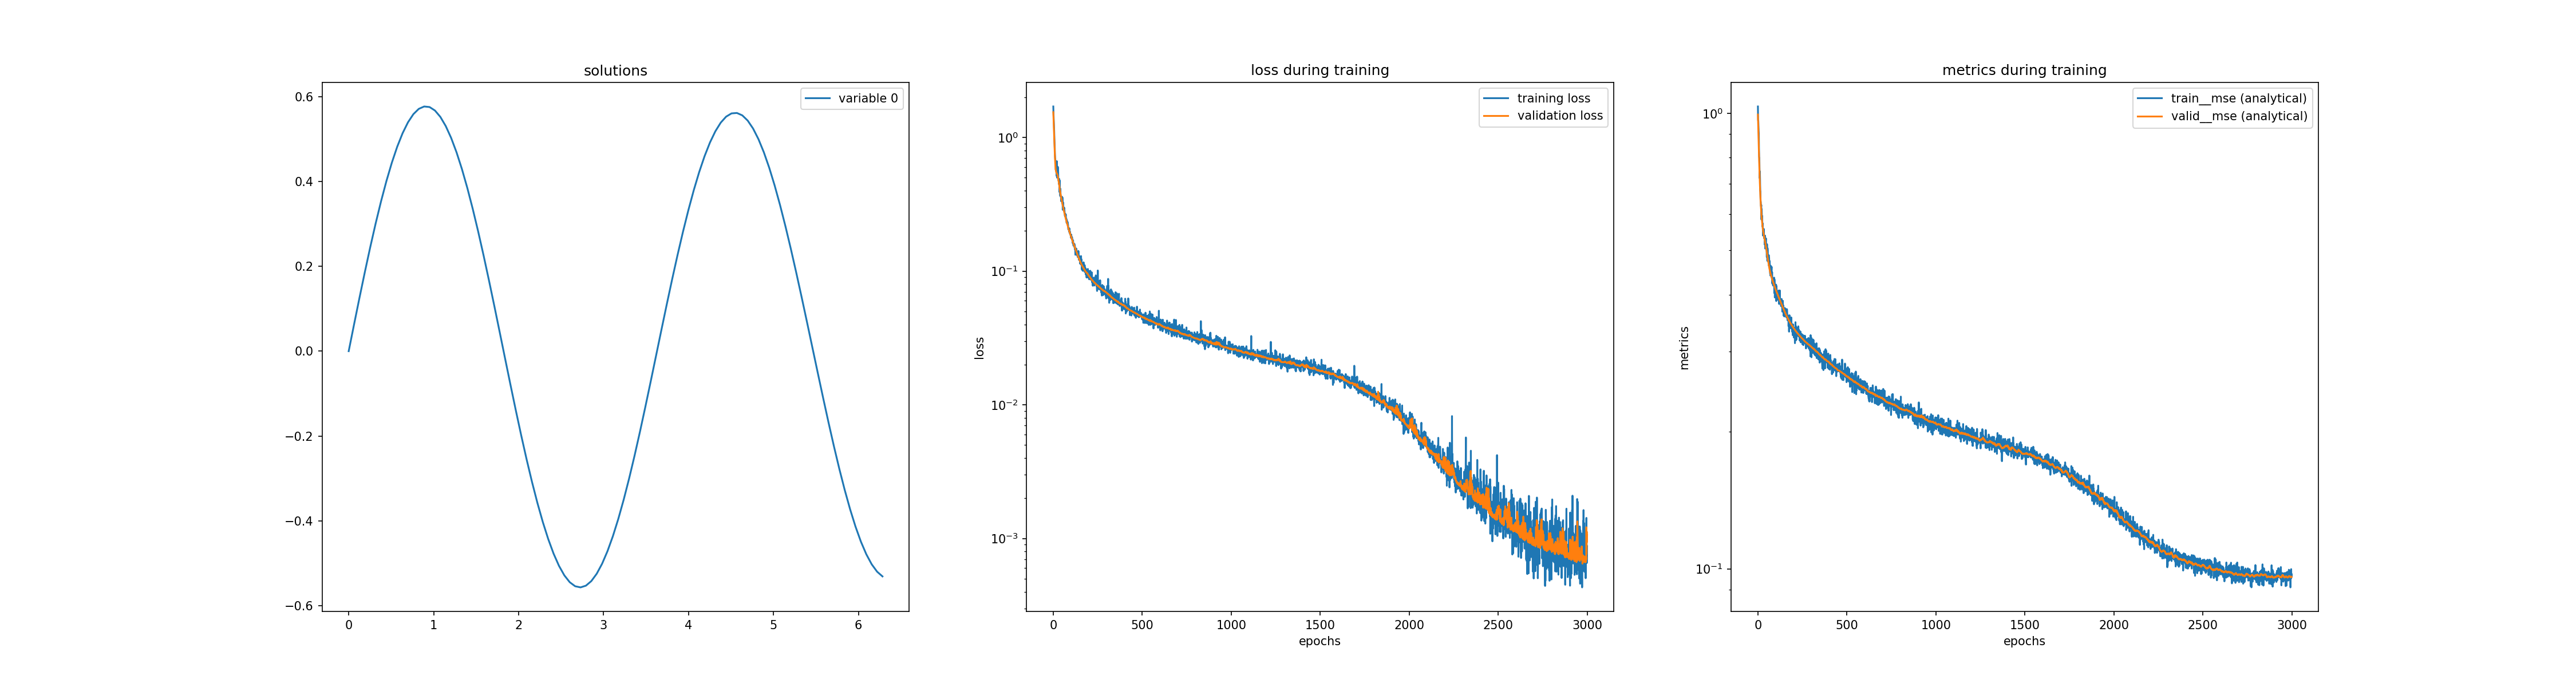

In [5]:
def mse(u, t):
    true_u = torch.sin(np.sqrt(3)*t)
    return torch.mean( (u - true_u)**2 )
pretrained = copy.deepcopy(solver_ho.get_internals()['best_nets'])

monitor2 = Monitor1D(t_min=0.0, t_max=2*np.pi)
# monitor_callback = MonitorCallback(monitor)

monitor_callback2 = PeriodLocal(period=100).set_action_callback(monitor2.to_callback())

# Instantiate a solver instance
solver_ho_cos_pre = Solver1D(
    ode_system=harmonic_oscillator_cos,
    conditions=init_vals_ho_cos,
    t_min=0.,
    t_max=2*np.pi,
    nets = pretrained,
    metrics = {'mse (analytical)':mse}
)

# Fit the solver (i.e., train the neural networks)
solver_ho_cos_pre.fit(max_epochs=3000,callbacks=[monitor_callback2])




The result above shows that using a pre-trained model can significantly improve learning/optimization over starting from scratch. You might ask - how robust is this? One way to test this is to look at whether we can perturb the initial conditions significantly so that pre-training is less important. If we try the initial conditions [0,1,0], this will result in a cosine curve. Lets see if pre-training helps in this setting.

#### Train the network from scratch with HO but with initial conditions that yield a cosine

In [ ]:
# %matplotlib notebook

def mse(u, t):
    true_u = torch.cos(t)
    return torch.mean( (u - true_u)**2 )

harmonic_oscillator_cos = lambda u, t: [ diff(u, t, order=2) + u ]
init_vals_ho_cos = [IVP(t_0=0.0, u_0=1.0, u_0_prime=0.0)]

monitor3 = Monitor1D(t_min=0.0, t_max=2*np.pi)
# monitor_callback = MonitorCallback(monitor)

monitor_callback3 = PeriodLocal(period=100).set_action_callback(monitor3.to_callback())

# Instantiate a solver instance
solver_ho_cos = Solver1D(
    ode_system=harmonic_oscillator_cos,
    conditions=init_vals_ho_cos,
    t_min=0.,
    t_max=2*np.pi,
    metrics = {'MSE (analytical)':mse}
)

# Fit the solver (i.e., train the neural networks)
solver_ho_cos.fit(max_epochs=3000,callbacks=[monitor_callback3])
print(f"train MSE:{solver_ho_cos.metrics_history['train__MSE (analytical)'][-1]}")

#### Use the pretrained model of sin(t) to optimize for cos(t)

In [ ]:
def mse(u, t):
    true_u = torch.cos(t)
    return torch.mean( (u - true_u)**2 )
pretrained = copy.deepcopy(solver_ho.get_internals()['best_nets'])

monitor4 = Monitor1D(t_min=0.0, t_max=2*np.pi)
monitor_callback4 = PeriodLocal(period=100).set_action_callback(monitor4.to_callback())

# Instantiate a solver instance
solver_ho_cos_pre = Solver1D(
    ode_system=harmonic_oscillator_cos,
    conditions=init_vals_ho_cos,
    t_min=0.,
    t_max=2*np.pi,
    nets = pretrained,
    metrics = {'MSE (analytical)':mse}
)

# Fit the solver (i.e., train the neural networks)
solver_ho_cos_pre.fit(max_epochs=3000,callbacks=[monitor_callback4])
print(f"train MSE:{solver_ho_cos_pre.metrics_history['train__MSE (analytical)'][-1]}")



So we see here that while we do recover the cosine curve by the end of training. Having pre-trained weights does not particularly improve the rate of convergence.

#### Training multiple networks

Given this result we might want to build a collection of pre-trained models. Formally, we want to train M different networks, each with their own initial conditions on the same differential equation. Then, using a 'similarity' metric between initial conditions we want to show that at least one of the networks can be used as a prior to speed up learning.

In [ ]:
seed = 2
np.random.seed(seed)

In [ ]:
N_inits = 3 #total conditions will be Ninits**2 because we specify u0 and u0prime
init_conds = [IVP(t_0=0.0,u_0=u_0_sample,u_0_prime=u_0_prime_sample) for u_0_sample in np.random.uniform(-1,1,N_inits) for u_0_prime_sample in np.random.uniform(-1,1,N_inits)]
# contrived addition of initial conditions close to those that generate cos
init_conds.append(IVP(t_0=0.0,u_0=0.97,u_0_prime=0.01))

In [ ]:
harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
network_db = []


for init_cond in init_conds:
    init_vals_ho = [init_cond]

    solver_ho = Solver1D(
        ode_system=harmonic_oscillator,
        conditions=init_vals_ho,
        t_min=0.,
        t_max=2*np.pi
    )

    # Fit the solver (i.e., train the neural networks)
    solver_ho.fit(max_epochs=3000)
    network_db.append(solver_ho)

now that we have our trained models, we need to find a similarity metric between our target initial conditions and the initial conditions used to generate the models. The closest prior (in terms of initial conditions) should be used to train the new network. However, it might be the case that our metric measure isn't perfec

### Metric 1: L2 norm between initial conditions

In [ ]:
#yields the cosine curve
test_init_cond = [IVP(t_0=0.0,u_0=1,u_0_prime=0)]

In [ ]:
similarity_vec = []
for init_cond in init_conds:
    sample = np.array([init_cond.u_0,init_cond.u_0_prime])
    test = np.array([test_init_cond[0].u_0,test_init_cond[0].u_0_prime])
    similarity_vec.append(((sample-test)**2).mean())

In [ ]:
min_dist=np.argmin(similarity_vec)

In [ ]:
print(f'the min distance between initial conditions occurs for model {min_dist}')

In [ ]:
for init_cond in init_conds:
    print(init_cond.u_0)

In [ ]:
%matplotlib inline
for mdl in network_db:
    sols = mdl.get_solution()
    ts = np.linspace(0,2*np.pi,100)
    u = sols(ts,to_numpy=True)
    plt.figure()
    plt.plot(u)

In [ ]:
%matplotlib inline
train_mse = []
for mdl in network_db:
    def mse(u, t):
        true_u = torch.cos(t)
        return torch.mean( (u - true_u)**2 )

    harmonic_oscillator_cos = lambda u, t: [ diff(u, t, order=2) + u ]
    init_vals_ho_cos = [IVP(t_0=0.0, u_0=1.0, u_0_prime=0.0)]

#     monitor1 = Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
#     monitor_callback1 = MonitorCallback(monitor1)

    # Instantiate a solver instance
    solver_ho_cos = Solver1D(
        ode_system=harmonic_oscillator_cos,
        conditions=init_vals_ho_cos,
        t_min=0.,
        t_max=2*np.pi,
        nets=copy.deepcopy(mdl.get_internals()['best_nets']),
        metrics = {'MSE (analytical)':mse}
    )

    # Fit the solver (i.e., train the neural networks)
    solver_ho_cos.fit(max_epochs=500)
    train_mse.append(solver_ho_cos.metrics_history['train__MSE (analytical)'][-1])

In [ ]:
train_mse

In [ ]:
print(f'min training MSE against the analytical occurs for model {np.argmin(train_mse)}')

We can see that being close in the initial condition space is not enough to find the model with the best pretrained model. In fact, this is obvious because different initial conditions induce different functional forms even if they have close initial conditions. As such, we need to account for the functional form of the solution to map closeness.

$$ M_q (query) = [Diffeq_q,IC_q,BV_q,NN_weights_q?,S_q?] $$
$$ M_k (key) = [Diffeq_k,IC_k,BV_k,NN_weights_k,S_k] $$

In [ ]:
### Metric 2: 

In [ ]:
x_metadata =[]
for mdl,init_cond in zip(network_db,init_conds):
    sols = mdl.get_solution()
    ts = np.linspace(0,2*np.pi,100)
    u = sols(ts,to_numpy=True)
    zinit = [init_cond.u_0,init_cond.u_0_prime]
    full_vec =np.concatenate([u,zinit])
    x_metadata.append(full_vec)

In [ ]:
import torch

model = torch.nn.Sequential(
          nn.Linear(2,100),
          nn.ReLU(),
          nn.Linear(100,100),
          nn.ReLU()
        )


## Testing Performance against a collection of diffeqs

In [ ]:
%matplotlib notebook


In [ ]:


#solve list of diffeqs, then use each as a pretrained for sigmoid

diffeqdb = []

harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

solver_ho = Solver1D(
    ode_system=harmonic_oscillator,
    conditions=init_val_ho,
    t_min=0,
    t_max=2.0,
)

solver_ho.fit(max_epochs=5000)


exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=1.0)]       # specify the initial conditon

solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=0,
    t_max=2.0,
)

solver_exp.fit(max_epochs=5000)


tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
init_val_tanh = [IVP(t_0=0.0, u_0=0.0)]     # specify the initial conditon


solver_tanh = Solver1D(
    ode_system=tanh,
    conditions=init_val_tanh,
    t_min=0,
    t_max=2.0,
)

solver_tanh.fit(max_epochs=5000)


In [ ]:
%matplotlib notebook
monitor2 = Monitor1D(t_min=0.0, t_max=2, check_every=100)
monitor_callback2 = MonitorCallback(monitor2)

sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon

solver_sigmoid = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)

solver_sigmoid.fit(max_epochs=5000,callbacks=[monitor_callback2])


In [ ]:
t = np.linspace(0,2,100)
ss =solver_sigmoid.get_solution()(t,to_numpy=True)
t = torch.linspace(0,2,100)
ana=torch.sigmoid(t).detach().numpy()
print(f'train from scratch:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

In [ ]:
monitor2 = Monitor1D(t_min=0.0, t_max=2, check_every=100)
monitor_callback2 = MonitorCallback(monitor2)

solver_sigm_pre = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
    nets=copy.deepcopy(solver_ho.get_internals()['best_nets']),
)

solver_sigm_pre.fit(max_epochs=5000,callbacks=[monitor_callback2])
ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
print(f'pretrain with HO:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

In [ ]:
monitor2 = Monitor1D(t_min=0.0, t_max=2, check_every=100)
monitor_callback2 = MonitorCallback(monitor2)

solver_sigm_pre = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
    nets=copy.deepcopy(solver_exp.get_internals()['best_nets']),
)

solver_sigm_pre.fit(max_epochs=5000,callbacks=[monitor_callback2])
ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
print(f'pretrain with exp:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

In [ ]:
monitor2 = Monitor1D(t_min=0.0, t_max=2, check_every=100)
monitor_callback2 = MonitorCallback(monitor2)

solver_sigm_pre = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
    nets=copy.deepcopy(solver_tanh.get_internals()['best_nets']),
)

solver_sigm_pre.fit(max_epochs=5000,callbacks=[monitor_callback2])
ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
print(f'pretrain with tanh:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

using the solution space as a basis to pretrain is not going to be a successful approach even in this simple case

#### Does partial pre-training help the fit?

In [ ]:
MAX_EPOCHS = 5000

sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon

solver_sigmoid = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)

solver_sigmoid.fit(max_epochs=MAX_EPOCHS)

t = torch.linspace(0,2,100)
ss =solver_sigmoid.get_solution()(t,to_numpy=True)
ana=torch.sigmoid(t).detach().numpy()
print(f'train from scratch:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

scratchfro = np.linalg.norm(ana-ss)
scratchmse = ((ss-ana)**2).mean()

In [ ]:
epochs = [50,200,500,1000]


errors = np.zeros((len(epochs),3,2))

for ep_dex,ep in enumerate(epochs):

    harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
    init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

    solver_ho = Solver1D(
        ode_system=harmonic_oscillator,
        conditions=init_val_ho,
        t_min=0,
        t_max=2.0,
    )

    solver_ho.fit(max_epochs=ep)


    exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
    init_val_ex = [IVP(t_0=0.0, u_0=1.0)]       # specify the initial conditon

    solver_exp = Solver1D(
        ode_system=exponential,
        conditions=init_val_ex,
        t_min=0,
        t_max=2.0,
    )

    solver_exp.fit(max_epochs=ep)


    tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
    init_val_tanh = [IVP(t_0=0.0, u_0=0.0)]     # specify the initial conditon


    solver_tanh = Solver1D(
        ode_system=tanh,
        conditions=init_val_tanh,
        t_min=0,
        t_max=2.0,
    )

    solver_tanh.fit(max_epochs=ep)

    
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_ho.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with HO:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,0,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,0,1] = ((ss-ana)**2).mean()
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_exp.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with exp:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,1,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,1,1] = ((ss-ana)**2).mean()
    
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_tanh.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with tanh:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,2,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,2,1] = ((ss-ana)**2).mean()
    

In [ ]:
%matplotlib inline


x = np.arange(len(epochs))  # the label locations
width = 0.2  # the width of the bars
ax.set_yscale('log')
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/1,errors[:,0,0] , width, label='HO')
rects2 = ax.bar(x, errors[:,1,0], width, label='EXP')
rects3 = ax.bar(x + width/1, errors[:,2,0] , width, label='TANH')

ax.hlines(scratchfro,-1,4,label='scratch')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frobenius Norm')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(epochs)
ax.legend()

In [ ]:
%matplotlib inline


x = np.arange(len(epochs))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/1,errors[:,0,1] , width, label='HO')
rects2 = ax.bar(x, errors[:,1,1], width, label='EXP')
rects3 = ax.bar(x + width/1, errors[:,2,1] , width, label='TANH')

ax.hlines(scratchmse,-1,4,label='scratch')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(epochs)
ax.legend()

Try re-running the scratch model and plotting the figures above. what you will find is that sometimes the scratch model performs worse than that of the others.

rerun experiments where the scratch model is run for 3000 epochs. the pretrained are trained for N epochs then used to pretrain for 1000 -N

In [ ]:
MAX_EPOCHS = 3000

sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon

solver_sigmoid = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)

solver_sigmoid.fit(max_epochs=MAX_EPOCHS)

t = torch.linspace(0,2,100)
ss =solver_sigmoid.get_solution()(t,to_numpy=True)
ana=torch.sigmoid(t).detach().numpy()
print(f'train from scratch:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

scratchfro = np.linalg.norm(ana-ss)
scratchmse = ((ss-ana)**2).mean()

In [ ]:
epochs = [50,200,500,1000]
MAX_EPOCHS = 1500

errors = np.zeros((len(epochs),3,2))

for ep_dex,ep in enumerate(epochs):

    harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
    init_val_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

    solver_ho = Solver1D(
        ode_system=harmonic_oscillator,
        conditions=init_val_ho,
        t_min=0,
        t_max=2.0,
    )

    solver_ho.fit(max_epochs=ep)


    exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
    init_val_ex = [IVP(t_0=0.0, u_0=1.0)]       # specify the initial conditon

    solver_exp = Solver1D(
        ode_system=exponential,
        conditions=init_val_ex,
        t_min=0,
        t_max=2.0,
    )

    solver_exp.fit(max_epochs=ep)


    tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
    init_val_tanh = [IVP(t_0=0.0, u_0=0.0)]     # specify the initial conditon


    solver_tanh = Solver1D(
        ode_system=tanh,
        conditions=init_val_tanh,
        t_min=0,
        t_max=2.0,
    )

    solver_tanh.fit(max_epochs=ep)

    
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_ho.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with HO:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,0,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,0,1] = ((ss-ana)**2).mean()
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_exp.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with exp:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,1,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,1,1] = ((ss-ana)**2).mean()
    
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_tanh.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with tanh:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,2,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,2,1] = ((ss-ana)**2).mean()
    

In [ ]:
%matplotlib inline


x = np.arange(len(epochs))  # the label locations
width = 0.2  # the width of the bars
ax.set_yscale('log')
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/1,errors[:,0,0] , width, label='HO')
rects2 = ax.bar(x, errors[:,1,0], width, label='EXP')
rects3 = ax.bar(x + width/1, errors[:,2,0] , width, label='TANH')

ax.hlines(scratchfro,-1,4,label='scratch')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frobenius Norm')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(epochs)
ax.legend()

In [ ]:
%matplotlib inline


x = np.arange(len(epochs))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/1,errors[:,0,1] , width, label='HO')
rects2 = ax.bar(x, errors[:,1,1], width, label='EXP')
rects3 = ax.bar(x + width/1, errors[:,2,1] , width, label='TANH')

ax.hlines(scratchmse,-1,4,label='scratch')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(epochs)
ax.legend()

- same equation, IC's need to be close
- perturb IC's in epsilon ball
- even if solutions are similar, not enough a prior for pre-training
- try different equations with same IC's
- do we have a regularizer variant?

#### Phase space as a function of epochs

In [ ]:

eps = np.linspace(10,5000,20).astype(int)
sol_coll = np.zeros((len(eps),2,100))

for idep,ep in enumerate(eps):

    def mse(u, t):
        true_u = torch.sin(t)
        return torch.mean( (u - true_u)**2 )

    harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
    init_vals_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

#     monitor = Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
#     monitor_callback = MonitorCallback(monitor)

    # Instantiate a solver instance
    solver_ho = Solver1D(
        ode_system=harmonic_oscillator,
        conditions=init_vals_ho,
        t_min=0.,
        t_max=2*np.pi, 
        metrics={'MSE (analytical)':mse}

    )

    # Fit the solver (i.e., train the neural networks)
    solver_ho.fit(max_epochs=ep)
    ts = torch.linspace(0,2*np.pi,100,requires_grad=True).view(-1,1)
    sols = solver_ho.get_solution()(ts)
    dsols = diff(sols,ts)
    sol_coll[idep,0,:] = sols.detach().numpy().ravel()
    sol_coll[idep,1,:] = dsols.detach().numpy().ravel()
    
# # Get the solution


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

In [ ]:
%matplotlib notebook
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2)
fig = plt.figure(figsize=(10,6))
def animate(i):
#     fig = plt.figure(figsize=(10,6))
    plt.clf()
    plt.title(f'epochs={eps[i]}')
    data = sol_coll[i] #select data range
    p = sns.scatterplot(x=data[0,:],y=data[1,:],color='royalblue',label='t')
    
    if i >0:
        data = sol_coll[i-1] #select data range
        p1 = sns.scatterplot(x=data[0,:],y=data[1,:],color='grey',label='t-1')
    plt.legend()
#     p.tick_params(labelsize=17)
#     plt.setp(p.lines,linewidth=7)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(eps), repeat=False)
ani.save('phasediffeq.mp4', writer=writer)

### Mathematical connection to phase-space and kernel

We know the kernel from https://arxiv.org/abs/2012.00152 is:

$$K(x,x') = \int_{c(t)} \nabla_w y(x)\cdot\nabla_w y(x')dt $$

Now, to show that this kernel is connected to gradient descent the authors show that:

in the limit of $\epsilon \rightarrow 0$:

$$ \frac{w_{s+1} -w_s}{\epsilon} = -\nabla_w L(w_s) $$

results in a differential equation:

$$\frac{dw(t)}{dt} = -\nabla_w L(w(t)) $$

then:
the rate of change of the target output (in our case the function 'u') with respect to epochs is:

$$ \frac{dy}{dt} = \sum_{j=1}^d \frac{\partial y}{\partial w_j} (-\frac{\partial L}{\partial w_j}) $$





$$ \frac{dy}{dt} = - \sum_{i=1}^m \frac{\partial L}{\partial y_i} \sum_{j=1}^d \frac{\partial y}{\partial w_j} \frac{\partial y_i}{\partial w_j} $$

It is indeed possible to break up the kernel even more using the chain rule:

$$ \frac{\partial y}{\partial w_j} = \frac{\partial y}{\partial x} \frac{\partial x}{\partial w_j} $$

We like the $dy/dx$ term because that gives us the phase-space momentum of the target solution which is connected to the dynamics of the underlying system here: $$\frac{dy}{dx} = D(x) $$.

but how do we compute the second term? 

One solution: We know that y(x) = F(x,w) where F combines the inputs and weights with non-linearities s.t. if G(y,w) = x then the NN is invertible. I'm not sure if this is typically possible but it seems to be a necessary condition to compute the second component of the equation above. 



Also to clarify - the kernel measures the similarity of the input variable. X is input in the models they show, however, in our case we simply have t. Querying t = 0 with t=5 doesn't make much sense since we can simply define a kernel directly on this without integration i.e. the input state space is of dim = 1. 

you might think - well that makes sense. your input should be [IC,BC,diffeq..]. Then the target will be u. But technically our input doesn't look like that. As such, we might want to build a larger network that takes the required input and appends it to the time variable to predict u. Then we will have a much clearer way to compare agains the different diffeqs/models but the input will be highly static.

Another thing to think about is: pre-training is good if we are close to the original diffeq

### connection between IC's,diffeq and solution

Pavlos mentioned training from scratch for 10 epochs, and comparing this to other networks that had trained for 10 epochs. Choosing the model weights of the final solution with 

In [ ]:
import pandas as pd

new_data = [['HO',2,0,0,0,1],
            ['EXP',1,0,0,1,None],
            ['TANH',1,1,1,0,None],
            ['PSIG',1,1,1,0,None]
           ]

database = pd.DataFrame(data=new_data,columns=['diffeq_name','diffeq_order','diffeq_homogeneity','diffeq_linearity','u_0','u_0_prime'])


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(database.iloc[:,1:-1].values)

In [ ]:
plt.figure()
trnsfrm = pca.transform(database.iloc[:,1:-1].values)

testpt = pd.DataFrame(['SIG',1,0,1,0.5,None])
trnsfrm_test = pca.transform(testpt.iloc[1:-1].values.reshape(1,-1))

for ind_nm,nm in enumerate(['HO','EXP','TANH']):
    plt.scatter(trnsfrm[ind_nm,0],trnsfrm[ind_nm,1],label=nm)
plt.scatter(trnsfrm_test[:,0],trnsfrm_test[:,1])

In [ ]:
np.linalg.norm(trnsfrm_test-trnsfrm,axis=1)

In [ ]:
np.repeat(trnsfrm_test,4,axis=0)

### Action Items next meeting

- same equation, IC's need to be close
- perturb IC's in epsilon ball
- even if solutions are similar, not enough a prior for pre-training
- try different equations with same IC's
- do we have a regularizer variant?

*******************

#### KERNEL METHOD

from our recent conversation we agreed on a few things:
- initial conditions should be the same
- we should compare apples to apples so first order methods with first order, otherwise the NN comparison doesn't make sense
- we should use the kernel method $K(m,m') = \int_{c(t)} \nabla_{w_m}y_m(x) \cdot \nabla_{w_{m'}}y_{m'}(x)dt $


In [5]:
MAX_EPOCHS = 300
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(0.5,2,1)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('exp',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=0,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('tanh',T_EVAL)
cb.set_action_callback(act_cb)
tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
init_val_tanh = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon
solver_tanh = Solver1D(
    ode_system=tanh,
    conditions=init_val_tanh,
    t_min=0,
    t_max=2.0,
)
solver_tanh.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])

cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('psig',T_EVAL)
cb.set_action_callback(act_cb)
perturbed_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_purt = Solver1D(
    ode_system=perturbed_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_purt.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('testsig',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('testsig2',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])




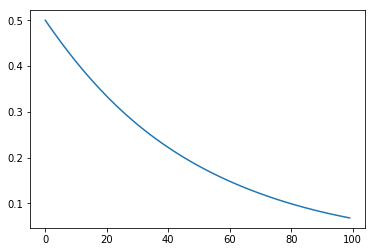

In [80]:
plt.plot(solver_exp.get_solution()(torch.linspace(0,2,100),to_numpy=True))

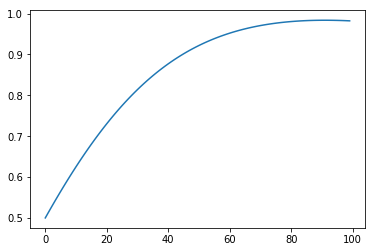

In [81]:
plt.plot(solver_tanh.get_solution()(torch.linspace(0,2,100),to_numpy=True))

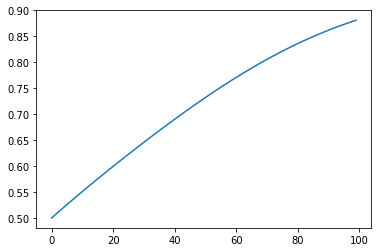

In [82]:
plt.plot(solver_sigmoid_test.get_solution()(torch.linspace(0,2,100),to_numpy=True))

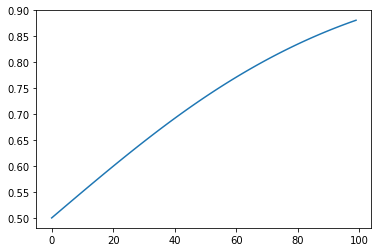

In [83]:
plt.plot(solver_sigmoid_purt.get_solution()(torch.linspace(0,2,100),to_numpy=True))

In [84]:
# MAX_EPOCHS = 3000
BURNIN = 5
equations = ['exp','tanh','psig','testsig','testsig2']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

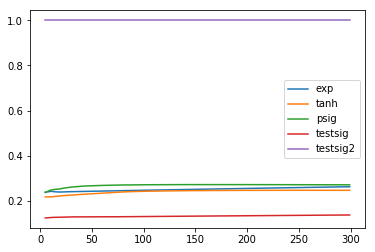

In [85]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()

- should we statistically average across these methods and multiple initial runs?
- should we rank the weights, these are indeed NN weights?

##### Ranked Weights

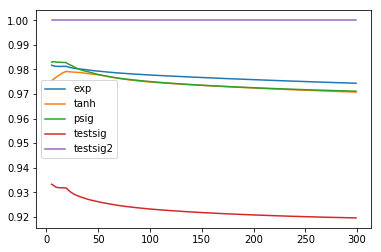

In [86]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

In [78]:
wdots

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

ranking weights leads to a strange problem where testsig with itself doesn't result in the highest score

In [ ]:
np.sum(np.abs(wdots),0)/np.sum(np.abs(wdots),0)[-1]

In [ ]:
wdots_df = pd.DataFrame(wdots)
wdots_df.rolling(2).mean().sum(axis=0).values/wdots_df.rolling(2).mean().sum(axis=0).values[-1]

- lets try cosine similarity?
- absolute weights dot product?
- weights have a lot of symmetries and so its hard to measure this cosine similarity across models

##### only dot product final iteration weights

In [ ]:
eps = [3000]
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)
      

In [ ]:
wdots

##### L2 norm instead of dot product of weights

In [ ]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=((np.sort(param_a)-np.sort(param_b))**2).mean()
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(wdots,0)[:,i],label=equations[i])
plt.legend()

In [66]:
clrs = ['blue','green','red','orange','yellow']

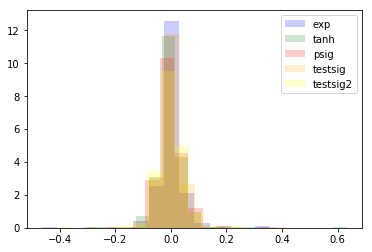

In [69]:
plt.figure()
for i in range(len(equations)):
    
    param_a = np.load(f'data/{equations[i]}/{5}.npy')
    plt.hist(param_a,density=True,bins=20,alpha=0.2,color=clrs[i],label=equations[i]);
plt.legend()


In [ ]:
param_a

In [ ]:
param_b

#### cosine similarity

In [ ]:
# meth_dex = 0
# wdots= np.zeros((len(eps),4))
# for meth_dex in range(4):
#     for ep_index,ep in enumerate(eps):
#         wdots[ep_index,meth_dex]=np.dot(mdl_weight_collector[ep_index][meth_dex],mdl_weight_collector[ep_index][3])/np.dot(np.linalg.norm(mdl_weight_collector[ep_index][meth_dex]),np.linalg.norm(mdl_weight_collector[ep_index][3]))


##### Frobenius Norm

In [ ]:
# meth_dex = 0
# wdots= np.zeros((len(eps),4))
# for meth_dex in range(4):
#     for ep_index,ep in enumerate(eps):
#         wdots[ep_index,meth_dex]= np.linalg.norm(mdl_weight_collector[ep_index][meth_dex]-mdl_weight_collector[ep_index][3])
        
# plt.figure()
# plt.plot(wdots)

######  

##### Summary of What DOES NOT WORK

- even if solutions are close, pretraining doesn't help much
- need to make sure the comparison of the methods is across the same order
- ensure ICs are similar
- kernel method fails even if we train the same model just with different inital weights
    - the weights are bottlenecked to certain regimes and NNs exhibit symmetries so the kernel doesn't reflect the right differences
    - kernel ranks don't help either.
    - kernel rank problem is that the kernel is applied across gradient descent theoretically not SGD

#### Does partial pre-training help the fit?

In [ ]:
MAX_EPOCHS = 3000

sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon

solver_sigmoid = Solver1D(
    ode_system=sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)

solver_sigmoid.fit(max_epochs=MAX_EPOCHS)

t = torch.linspace(0,2,100)
ss =solver_sigmoid.get_solution()(t,to_numpy=True)
ana=torch.sigmoid(t).detach().numpy()
print(f'train from scratch:{np.linalg.norm(ana-ss)}')
print(f'MSE:{((ss-ana)**2).mean()}')

scratchfro = np.linalg.norm(ana-ss)
scratchmse = ((ss-ana)**2).mean()

In [ ]:
epochs = [50,200,500,1000]


errors = np.zeros((len(epochs),2,2))

for ep_dex,ep in enumerate(epochs):

    exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
    init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon

    solver_exp = Solver1D(
        ode_system=exponential,
        conditions=init_val_ex,
        t_min=0,
        t_max=2.0,
    )

    solver_exp.fit(max_epochs=ep)


    tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
    init_val_tanh = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon


    solver_tanh = Solver1D(
        ode_system=tanh,
        conditions=init_val_tanh,
        t_min=0,
        t_max=2.0,
    )

    solver_tanh.fit(max_epochs=ep)

    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_exp.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with exp:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,0,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,0,1] = ((ss-ana)**2).mean()
    
    
    solver_sigm_pre = Solver1D(
        ode_system=sigmoid,
        conditions=init_val_sig,
        t_min=0,
        t_max=2.0,
        nets=copy.deepcopy(solver_tanh.get_internals()['best_nets']),
    )

    solver_sigm_pre.fit(max_epochs=MAX_EPOCHS-ep)
    ss =solver_sigm_pre.get_solution()(t,to_numpy=True)
    print(f'pretrain with tanh:{np.linalg.norm(ana-ss)}')
    print(f'MSE:{((ss-ana)**2).mean()}')
    errors[ep_dex,1,0] = np.linalg.norm(ana-ss)
    errors[ep_dex,1,1] = ((ss-ana)**2).mean()
    

In [ ]:
%matplotlib inline


x = np.arange(len(epochs))  # the label locations
width = 0.2  # the width of the bars
ax.set_yscale('log')
fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/1,errors[:,0,0] , width, label='HO')
rects2 = ax.bar(x, errors[:,0,0], width, label='EXP')
rects3 = ax.bar(x + width/1, errors[:,1,0] , width, label='TANH')

ax.hlines(scratchfro,-1,4,label='scratch')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frobenius Norm')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(epochs)
ax.legend()

In [ ]:
%matplotlib inline


x = np.arange(len(epochs))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/1,errors[:,0,1] , width, label='HO')
rects2 = ax.bar(x, errors[:,0,1], width, label='EXP')
rects3 = ax.bar(x + width/1, errors[:,1,1] , width, label='TANH')

ax.hlines(scratchmse,-1,4,label='scratch')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(epochs)
ax.legend()

#### gradient flows?


#epsilon ball for the init conditions

# quick PDE

In [ ]:
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
import torch

In [ ]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [
    diff(u, x, order=2) + diff(u, y, order=2)
]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: torch.sin(np.pi*y),
        x_max=1, x_max_val=lambda y: 0,
        y_min=0, y_min_val=lambda x: 0,
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=[512])
]

# Define the monitor callback
monitor=Monitor2D(xy_min=(0, 0), xy_max=(1, 1),check_every=10)
monitor_callback = MonitorCallback(monitor)#PeriodLocal(period=10).set_action_callback(monitor.to_callback())

# Instantiate the solver
solver = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=200, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver.get_solution()

In [ ]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [
    diff(u, x, order=2) + 5*diff(u, y, order=2)
]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: -torch.sin(np.pi*y),
        x_max=1, x_max_val=lambda y: 0,
        y_min=0, y_min_val=lambda x: 0,
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
# nets = [
#     FCNN(n_input_units=2, n_output_units=1, hidden_units=[512])
# ]

# Define the monitor callback
monitor=Monitor2D(xy_min=(0, 0), xy_max=(1, 1),check_every=10)
monitor_callback = MonitorCallback(monitor)#PeriodLocal(period=10).set_action_callback(monitor.to_callback())

# Instantiate the solver
solver_pre = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=solver.get_internals()['best_nets'],#nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver_pre.fit(max_epochs=200, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver_pre.get_solution()

In [ ]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [
    diff(u, x, order=2) + 5*diff(u, y, order=2)
]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: -torch.sin(np.pi*y),
        x_max=1, x_max_val=lambda y: 0,
        y_min=0, y_min_val=lambda x: 0,
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=[512])
]

# Define the monitor callback
monitor=Monitor2D(xy_min=(0, 0), xy_max=(1, 1),check_every=10)
monitor_callback = MonitorCallback(monitor)#PeriodLocal(period=10).set_action_callback(monitor.to_callback())

# Instantiate the solver
solver1 = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver1.fit(max_epochs=200, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_laplace = solver1.get_solution()

### epsilon ball analysis

In [ ]:
u_0s = np.linspace(-0.2,0.2,50)

In [ ]:
mdl_params = []
for u_0 in u_0s:
    # def mse(u, t):
    #     true_u = torch.sin(t)
    #     return torch.mean( (u - true_u)**2 )

    harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
    init_vals_ho = [IVP(t_0=0.0, u_0=u_0, u_0_prime=1.0)]

    monitor = Monitor1D(t_min=0.0, t_max=2*np.pi)
    # monitor_callback = MonitorCallback(monitor)

    monitor_callback = PeriodLocal(period=100).set_action_callback(monitor.to_callback())

    # Instantiate a solver instance
    solver_ho = Solver1D(
        ode_system=harmonic_oscillator,
        conditions=init_vals_ho,
        t_min=0.,
        t_max=2*np.pi, 
        metrics={'MSE (analytical)':mse}

    )

    # Fit the solver (i.e., train the neural networks)
    solver_ho.fit(max_epochs=3000, callbacks=[monitor_callback])

    mdl_params.append(solver_ho.get_internals()['best_nets'])
    # # Get the solution


In [ ]:
mdl_params = []
for i,u_0 in enumerate(u_0s):
    def mse(u, t):
        true_u = torch.sin(t)
        return torch.mean( (u - true_u)**2 )

    harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
    init_vals_ho = [IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]

    monitor = Monitor1D(t_min=0.0, t_max=2*np.pi)
    # monitor_callback = MonitorCallback(monitor)

    monitor_callback = PeriodLocal(period=100).set_action_callback(monitor.to_callback())

    # Instantiate a solver instance
    solver_ho = Solver1D(
        ode_system=harmonic_oscillator,
        conditions=init_vals_ho,
        t_min=0.,
        t_max=2*np.pi, 
        nets=mdl_params[i],
        metrics={'MSE (analytical)':mse}

    )

    # Fit the solver (i.e., train the neural networks)
    solver_ho.fit(max_epochs=1000, callbacks=[monitor_callback])

#     mdl_params.append(solver_ho.get_internals()['best_nets'])
    # # Get the solution


#### check gradients

In [7]:
exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon

solver_exp = Solver1D(
        ode_system=exponential,
        conditions=init_val_ex,
        t_min=0,
        t_max=2.0,
    )

solver_exp.fit(max_epochs=3000)


# sols1 = solver_exp.get_solution()(ts).detach().numpy()

# mdl = solver_exp.get_internals()['best_nets'][0]
# ts = torch.linspace(0,2,100)
# sols2 = mdl(ts.reshape(-1,1))


In [11]:
ts = torch.linspace(1,2,100)

solution = solver_exp.get_solution()
for net in solution.nets:
    for param in net.parameters():
        print(param.grad)

None
None
None
None
None
None


In [14]:
solution = solver_exp.get_solution()
solution.nets[0].zero_grad()
u = solution(ts)
u.backward(torch.ones_like(u))
for net in solution.nets:
    for param in net.parameters():
        print(param.grad.detach().numpy())

solution.nets[0].zero_grad()

for net in solution.nets:
    for param in net.parameters():
        print(param.grad)

[[-6.83339388e-01]
 [-1.97409778e+00]
 [ 7.93979881e-01]
 [ 9.82458844e-01]
 [ 1.85606289e+00]
 [ 2.19578314e+00]
 [ 1.03978018e+00]
 [ 7.99615160e-02]
 [ 2.11665833e+00]
 [-3.47555723e+00]
 [-5.29314901e-01]
 [-3.33085165e+00]
 [-5.82941490e-01]
 [-5.54145607e+00]
 [ 9.12340461e+00]
 [ 4.07021493e-01]
 [ 7.28528223e-01]
 [ 2.51042066e+00]
 [ 6.75606442e-03]
 [-3.90917657e+00]
 [ 6.64217505e+00]
 [ 1.24045402e-01]
 [ 1.46275972e+00]
 [-5.24989112e+00]
 [-1.18669425e+00]
 [ 4.54187289e+00]
 [ 9.43912908e+00]
 [-1.16058676e+00]
 [-5.90818162e+00]
 [-3.26464525e+00]
 [-3.38915347e+00]
 [ 4.78755864e+00]]
[-4.78795194e-01 -1.29847040e+00  5.34809375e-01  6.70022325e-01
  1.29326205e+00  1.41087986e+00  6.91346713e-01  4.86719034e-02
  1.48951280e+00 -2.28424005e+00 -3.71140432e-01 -2.18238873e+00
 -3.73252400e-01 -3.72066220e+00  5.99273523e+00  2.93360717e-01
  5.10929487e-01  1.69852486e+00  4.61051301e-03 -2.67066994e+00
  4.33779207e+00  8.67202505e-02  9.81395314e-01 -3.50389185e+00
 

In [ ]:
plt.figure()
plt.plot(sols1,label='sols1')
plt.plot(sols2.detach().numpy(),label='sols2')
plt.legend()

In [ ]:
mdl = solver_exp.get_internals()['best_nets'][0]
ts = torch.linspace(0,2,100)
lvalues = mdl(ts.reshape(-1,1))

In [ ]:
plt.plot(lvalues.detach().numpy())

In [ ]:
lvalues = mdl(ts.reshape(-1,1))

In [ ]:
mdl.zero_grad()
lvalues = mdl(ts)
lvalues.sum().backward()
model_weights = []
for param in mdl.parameters():
    model_weights.append(param.grad.detach().numpy().ravel())

fin_weights = np.concatenate(model_weights)
print(fin_weights)

In [ ]:
mdl = solver_exp.get_internals()['best_nets'][0]
ts = torch.linspace(0,2,100)

mdl.zero_grad()
lvalues = mdl(ts.reshape(-1, 1))
lvalues.sum().backward()
model_weights = []
for param in mdl.parameters():
    model_weights.append(param.grad.detach().numpy().ravel())

fin_weights = np.concatenate(model_weights)
print(fin_weights)

In [ ]:
plt.plot(lvalues.detach().numpy())

#### things to do

- dy/dx instead of dy/dw
- y*dy/dx
- KL divergence between weights at each iteration between the kernel fits
- also directly use weights instead of dy/dw
- 

### 

- ensure dy/dw is being computed correctly
- check the cosine similarity of vectors from different models (sadly the connection across models isn't consistent)
- check the cosine similarity on the ranked weights
- try the absolute difference between the weights
- fit kernels to the weights and use KL divergence


#### $\frac{dy}{dw}$ Weights

In [3]:
MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(.7,2,100)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('exp',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=0,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('tanh',T_EVAL)
cb.set_action_callback(act_cb)
tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
init_val_tanh = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon
solver_tanh = Solver1D(
    ode_system=tanh,
    conditions=init_val_tanh,
    t_min=0,
    t_max=2.0,
)
solver_tanh.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])

cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('psig',T_EVAL)
cb.set_action_callback(act_cb)
perturbed_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_purt = Solver1D(
    ode_system=perturbed_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_purt.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('testsig',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback('testsig2',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test2 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test2.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])




In [4]:
# MAX_EPOCHS = 3000
BURNIN = 20
equations = ['exp','tanh','psig','testsig','testsig2']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

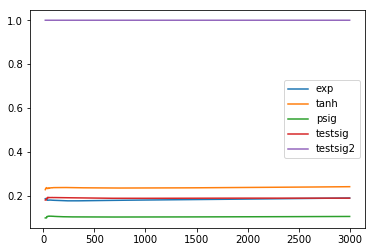

In [5]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()

##### Ranked Weights

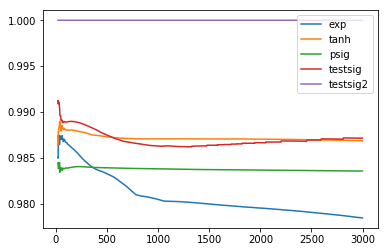

In [10]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

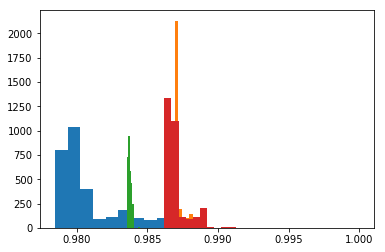

In [11]:
plt.figure()
for i in range(wdots.shape[1]):
    plt.hist(wdots[:,i],label='')

### abs diff

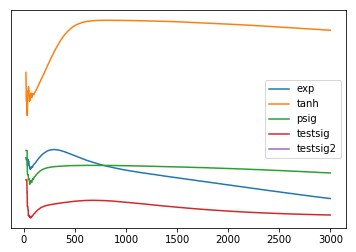

In [9]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]= np.linalg.norm(param_a-param_b,ord=2)
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
plt.yscale('log')

### distribution comparison

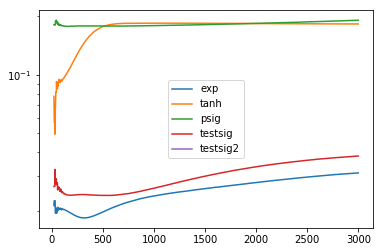

In [28]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        
        s1 = norm(loc=param_a.mean(),scale=param_a.std())
        r1 = s1.pdf(np.linspace(-20,20,500))
    
        s2 = norm(loc=param_b.mean(),scale=param_b.std())
        r2 = s2.pdf(np.linspace(-20,20,500))
    
        wdots[ep_index,meth_dex]= (r1*np.log(r1/r2)).sum()
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
plt.yscale('log')

In [16]:
from scipy.stats import norm

In [18]:
ss = norm(loc=param_a.mean(),scale=param_a.std())

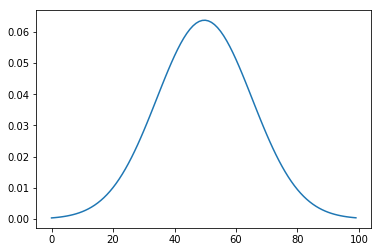

In [26]:
ss.pdf(np.linspace(-20,20,100))

#### Weights Alone

In [36]:


DIFFEQS_TRAIN = {
'exp1':lambda u,t: [diff(u, t) + u],
'exp12':lambda u,t: [diff(u, t) - u],
'tanh1': lambda u,t:[diff(u, t) + u**2 -1],
'psig1':lambda u,t: [diff(u, t) -3*u +u**2],
'r11': lambda u,t:[diff(u, t) -u +u**2 +u**3],
'r12': lambda u,t:[diff(u, t) +u +u**2],
'r13': lambda u,t:[diff(u, t) +u**2],
'r14': lambda u,t:[diff(u, t) -u**2],
'sigmoid1': lambda u,t:[diff(u, t) -u + u**2],
'sigmoid12': lambda u,t:[diff(u, t) -u +u**2],
}

MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1
eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]
INIT_VAL = [IVP(t_0=0.0, u_0=0.5)]
T_MIN = 0.0
T_MAX=2.0
T_EVAL = torch.linspace(T_MIN,T_MAX,100)


for system_name,system in DIFFEQS_TRAIN.items():
    # solver changes NETS in place so we re-initialize every time we run this
    NETS = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=[10])
    ]
    #call the weights
    cb0 = PeriodLocal(period=SUB_RATE)
    wcb0 = WeightCallback(system_name,T_EVAL)
    cb0.set_action_callback(wcb0)
    #call the solutions
    cb1 = PeriodLocal(period=SUB_RATE)
    wcb1 = SolutionCallback(system_name,T_EVAL)
    cb1.set_action_callback(wcb1)

    solver = Solver1D(
        ode_system=system,
        conditions=INIT_VAL,
        t_min=T_MIN,
        t_max=T_MAX,
        nets = NETS
    )
    solver.fit(max_epochs=MAX_EPOCHS,callbacks=[cb0,cb1])
    
    



KeyboardInterrupt: 

In [15]:
# MAX_EPOCHS = 3000
BURNIN = 1
equations = ['exp1','tanh1','psig1','testsig1','testsig21']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

Text(0.5, 1.0, 'Epoch 2999 Weight Distribution')

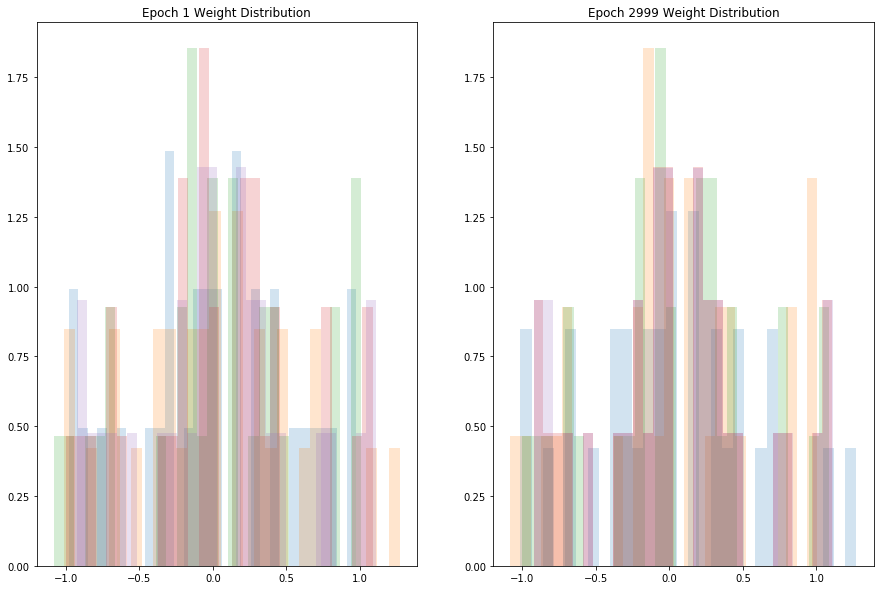

In [29]:
fig,ax = plt.subplots(1,2,figsize=(15,10))

ep= 1

for method in equations:
    param_a = np.load(f'data/{method}/{ep}.npy')
    ax[0].hist(param_a,density=True,label=method,bins=30,alpha=.2)

ax[0].set_title('Epoch 1 Weight Distribution')

ep= 2999

for method in equations:
    param_a = np.load(f'data/{method}/{ep}.npy')
    ax[1].hist(param_a,density=True,label=method,bins=30,alpha=.2)
ax[1].set_title('Epoch 2999 Weight Distribution')


#### weight cosine similarity

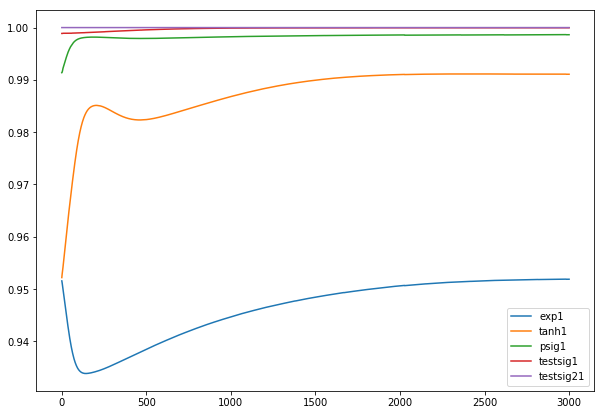

In [30]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))
plt.figure(figsize=(10,7))
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()

##### Ranked Weights

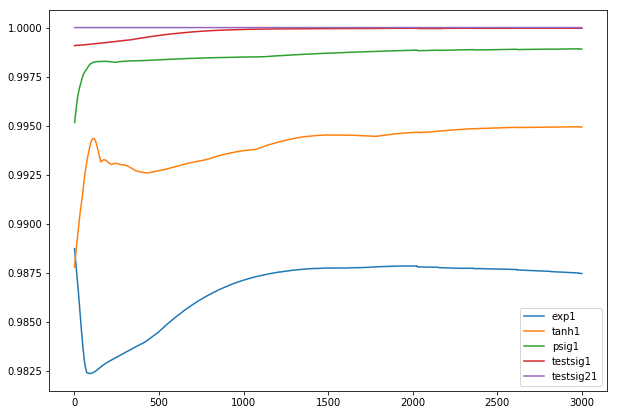

In [27]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(np.sort(param_a),ord=2)*np.linalg.norm(np.sort(param_b),ord=2))
        
plt.figure(figsize=(10,7))
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

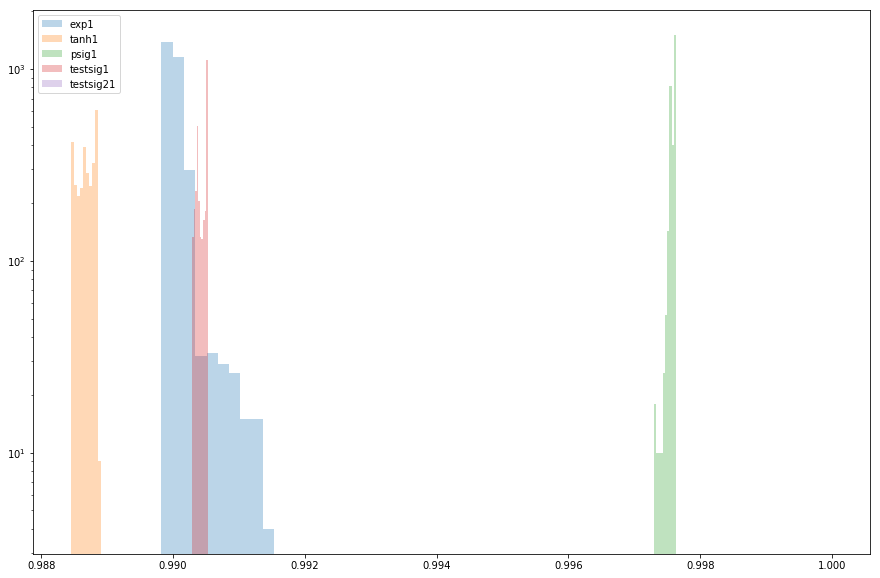

In [48]:
plt.figure(figsize=(15,10))
for i in range(wdots.shape[1]):
    plt.hist(wdots[:,i],label=equations[i],alpha=.3)
plt.legend()
plt.yscale('log')

### abs diff

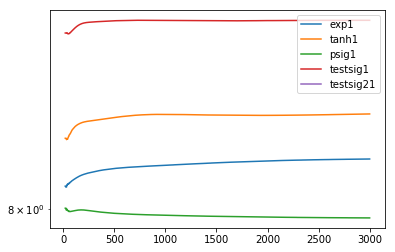

In [50]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]= np.linalg.norm(param_a-param_b,ord=2)
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
plt.yscale('log')

### distribution comparison

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


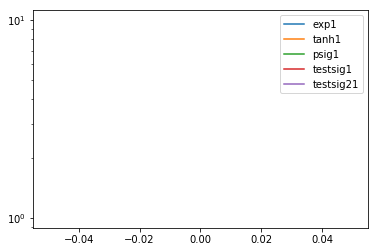

In [51]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        
        s1 = norm(loc=param_a.mean(),scale=param_a.std())
        r1 = s1.pdf(np.linspace(-20,20,500))
    
        s2 = norm(loc=param_b.mean(),scale=param_b.std())
        r2 = s2.pdf(np.linspace(-20,20,500))
    
        wdots[ep_index,meth_dex]= (r2*np.log(r2/r1)).sum()
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
plt.yscale('log')

#### Direct Weights

In [13]:
MAX_EPOCHS = 1000
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(0.5,2,1)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('exp1',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=0,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('tanh1',T_EVAL)
cb.set_action_callback(act_cb)
tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
init_val_tanh = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon
solver_tanh = Solver1D(
    ode_system=tanh,
    conditions=init_val_tanh,
    t_min=0,
    t_max=2.0,
)
solver_tanh.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])

cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('psig1',T_EVAL)
cb.set_action_callback(act_cb)
perturbed_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_purt = Solver1D(
    ode_system=perturbed_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_purt.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('testsig1',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('testsig21',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test2 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test2.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])




In [34]:
# MAX_EPOCHS = 3000
BURNIN = 50
equations = ['exp1','tanh1','psig1','testsig1','testsig21']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

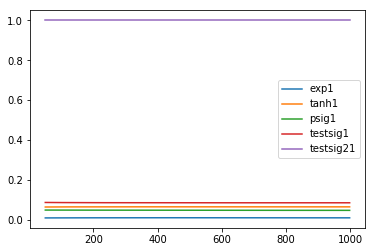

In [35]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()

##### Ranked Weights

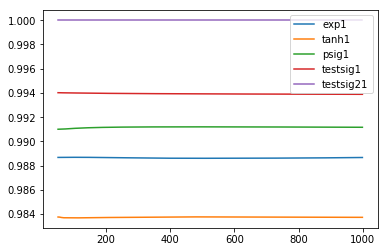

In [36]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

### weights distribution

In [30]:
ep = 2995
param_a = np.load(f'data/{equations[0]}/{ep}.npy')
param_b = np.load(f'data/{equations[-1]}/{ep}.npy')

(array([0.00663799, 0.01327597, 0.03318994, 2.58881512, 4.90547275,
        0.03982792, 0.03318994, 0.01991396, 0.00663799, 0.00663799]),
 array([-0.52970492, -0.39904744, -0.26838997, -0.13773249, -0.00707502,
         0.12358246,  0.25423994,  0.38489741,  0.51555489,  0.64621236,
         0.77686984]),
 <a list of 10 Patch objects>)

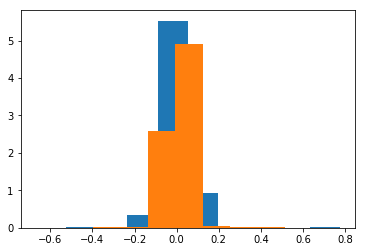

In [31]:
plt.figure()
plt.hist(param_a,density=True)
plt.hist(param_b,density=True)

#### Direct Weights

In [13]:
MAX_EPOCHS = 1000
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(0.5,2,1)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('exp1',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=0,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('tanh1',T_EVAL)
cb.set_action_callback(act_cb)
tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
init_val_tanh = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon
solver_tanh = Solver1D(
    ode_system=tanh,
    conditions=init_val_tanh,
    t_min=0,
    t_max=2.0,
)
solver_tanh.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])

cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('psig1',T_EVAL)
cb.set_action_callback(act_cb)
perturbed_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_purt = Solver1D(
    ode_system=perturbed_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_purt.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('testsig1',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('testsig21',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test2 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test2.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])




In [34]:
# MAX_EPOCHS = 3000
BURNIN = 50
equations = ['exp1','tanh1','psig1','testsig1','testsig21']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

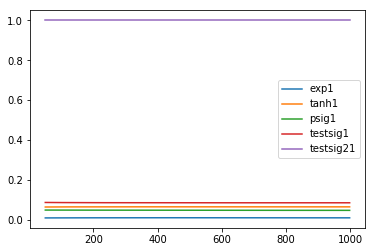

In [35]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()

##### Ranked Weights

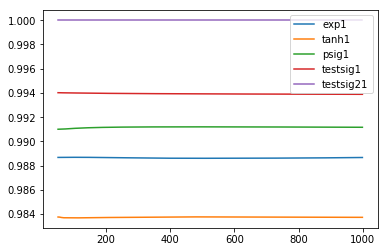

In [36]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

using the weights or dy/dw isn't informative. we can try to use dy/dx but that is equivlent to comparing the solution. We could try a joint qp metric.

#### solution mapping

In [70]:
MAX_EPOCHS = 100
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(0.5,2,1)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('exp1',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t) + u] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=0,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('tanh1',T_EVAL)
cb.set_action_callback(act_cb)
tanh = lambda u, t: [diff(u, t) + u**2 -1] # specify the ODE
init_val_tanh = [IVP(t_0=0.0, u_0=0.5)]     # specify the initial conditon
solver_tanh = Solver1D(
    ode_system=tanh,
    conditions=init_val_tanh,
    t_min=0,
    t_max=2.0,
)
solver_tanh.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])

cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('psig1',T_EVAL)
cb.set_action_callback(act_cb)
perturbed_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_purt = Solver1D(
    ode_system=perturbed_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_purt.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('testsig1',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('testsig21',T_EVAL)
cb.set_action_callback(act_cb)
test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=1.)]     # specify the initial conditon
solver_sigmoid_test2 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=0,
    t_max=2.0,
)
solver_sigmoid_test2.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])




In [71]:
us_exp = solver_exp.get_solution()(ts)
dudt_exp = diff(us_exp,ts)

In [72]:
ts = torch.linspace(0,2,100,requires_grad=True).reshape(-1,1)

us_exp = solver_exp.get_solution()(ts)
dudt_exp = diff(us_exp,ts)
vec_exp = (dudt_exp*us_exp).detach().numpy()

us_tanh = solver_tanh.get_solution()(ts)
dudt_tanh = diff(us_tanh,ts)
vec_tanh = (dudt_tanh*us_tanh).detach().numpy()

us_sig1 = solver_sigmoid_purt.get_solution()(ts)
dudt_sig1 = diff(us_sig1,ts)
vec_sig1 = (us_sig1*dudt_sig1).detach().numpy()

us_sigtest = solver_sigmoid_test.get_solution()(ts)
dudt_sigtest = diff(us_sigtest,ts)
vec_sigtest = (us_sigtest*dudt_sigtest).detach().numpy()

us_sigtest2 = solver_sigmoid_test2.get_solution()(ts)
dudt_sigtest2 = diff(us_sigtest2,ts)
vec_sigtest2 = (us_sigtest2*dudt_sigtest2).detach().numpy()

The solution at the 100th epoch can be used to compare - but this would really be a problem with cosine and sine.. we hope that the weights learn an underlying representation useful for transfer.

In [65]:
((vec_exp - vec_sigtest)**2).mean()

0.04263164435521143

In [66]:
((vec_tanh - vec_sigtest)**2).mean()

0.015944930785674355

In [67]:
((vec_sig1 - vec_sigtest)**2).mean()

1.0368649273154875e-05

In [73]:
((vec_sigtest2 - vec_sigtest)**2).mean()

0.017895323901821837

In [34]:
# MAX_EPOCHS = 3000
BURNIN = 50
equations = ['exp1','tanh1','psig1','testsig1','testsig21']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

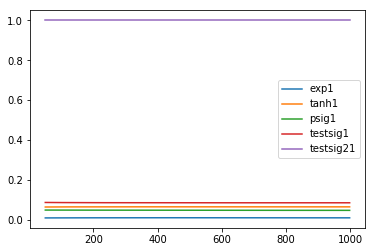

In [35]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()

##### Ranked Weights

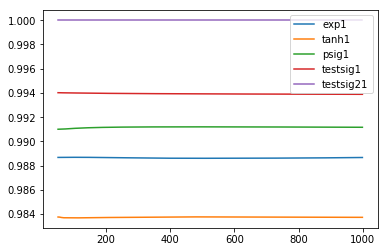

In [36]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

using the weights or dy/dw isn't informative. we can try to use dy/dx but that is equivlent to comparing the solution. We could try a joint qp metric.

#### 

In [36]:
MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(0.5,2,1)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('exp1',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t)-u+u**2] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=-2.,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])



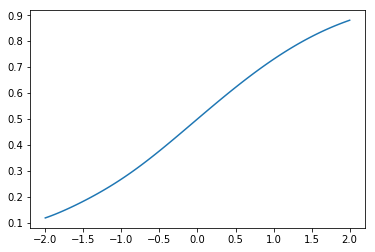

In [38]:
ts = torch.linspace(-2,2,100)
sols = solver_exp.get_solution()(ts,to_numpy=True)
plt.plot(ts.detach().numpy(),sols)

In [14]:
for param in (solver_exp.nets[0]).parameters():
    print(param)


Parameter containing:
tensor([[-0.6234],
        [-0.4825],
        [-0.4797],
        [ 0.7175],
        [ 0.4618],
        [-0.5874],
        [ 0.4158],
        [-0.5045],
        [ 0.2694],
        [ 0.4619],
        [ 0.4420],
        [-0.7583],
        [-0.0689],
        [-0.1621],
        [ 0.7429],
        [ 0.3287],
        [ 0.0019],
        [ 0.0156],
        [-0.4506],
        [-0.5204],
        [ 0.1074],
        [-0.0353],
        [-0.0489],
        [-0.2013],
        [ 0.8048],
        [-0.5709],
        [ 0.5071],
        [ 0.2266],
        [-0.5517],
        [ 0.0435],
        [-0.1881],
        [ 0.7034]], requires_grad=True)
Parameter containing:
tensor([-0.0656,  0.9533, -0.4622, -0.9906,  0.6088,  0.4050,  0.4968,  0.5733,
         0.2727, -0.1756, -0.4755,  0.7543, -0.3404,  0.6988, -0.8310, -0.7107,
         0.1254, -0.6880,  0.5160, -0.1021,  0.5461, -0.9538, -0.3895,  0.5421,
        -0.1903,  0.2782,  0.1903, -0.3090, -0.5044,  0.8546, -0.2537,  0.8195],
      